# Finding Lane Lines (Advanced)

## Import Project Dependencies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Define Constants

In [2]:
CALIBRATION_DIR = "camera_cal"
CALIBRATION_FILE = "camera_calibration.npy"
TEST_IMAGES_DIR = "test_images"
INPUT_VIDEOS_DIR = "input_videos"
OUTPUT_VIDEOS_DIR = "output_videos"

METERS_PER_PX_Y = 30. / 720. # meters per pixel in y dimension
METERS_PER_PX_X = 3.7 / 700. # meters per pixel in x dimension

## Camera Calibration

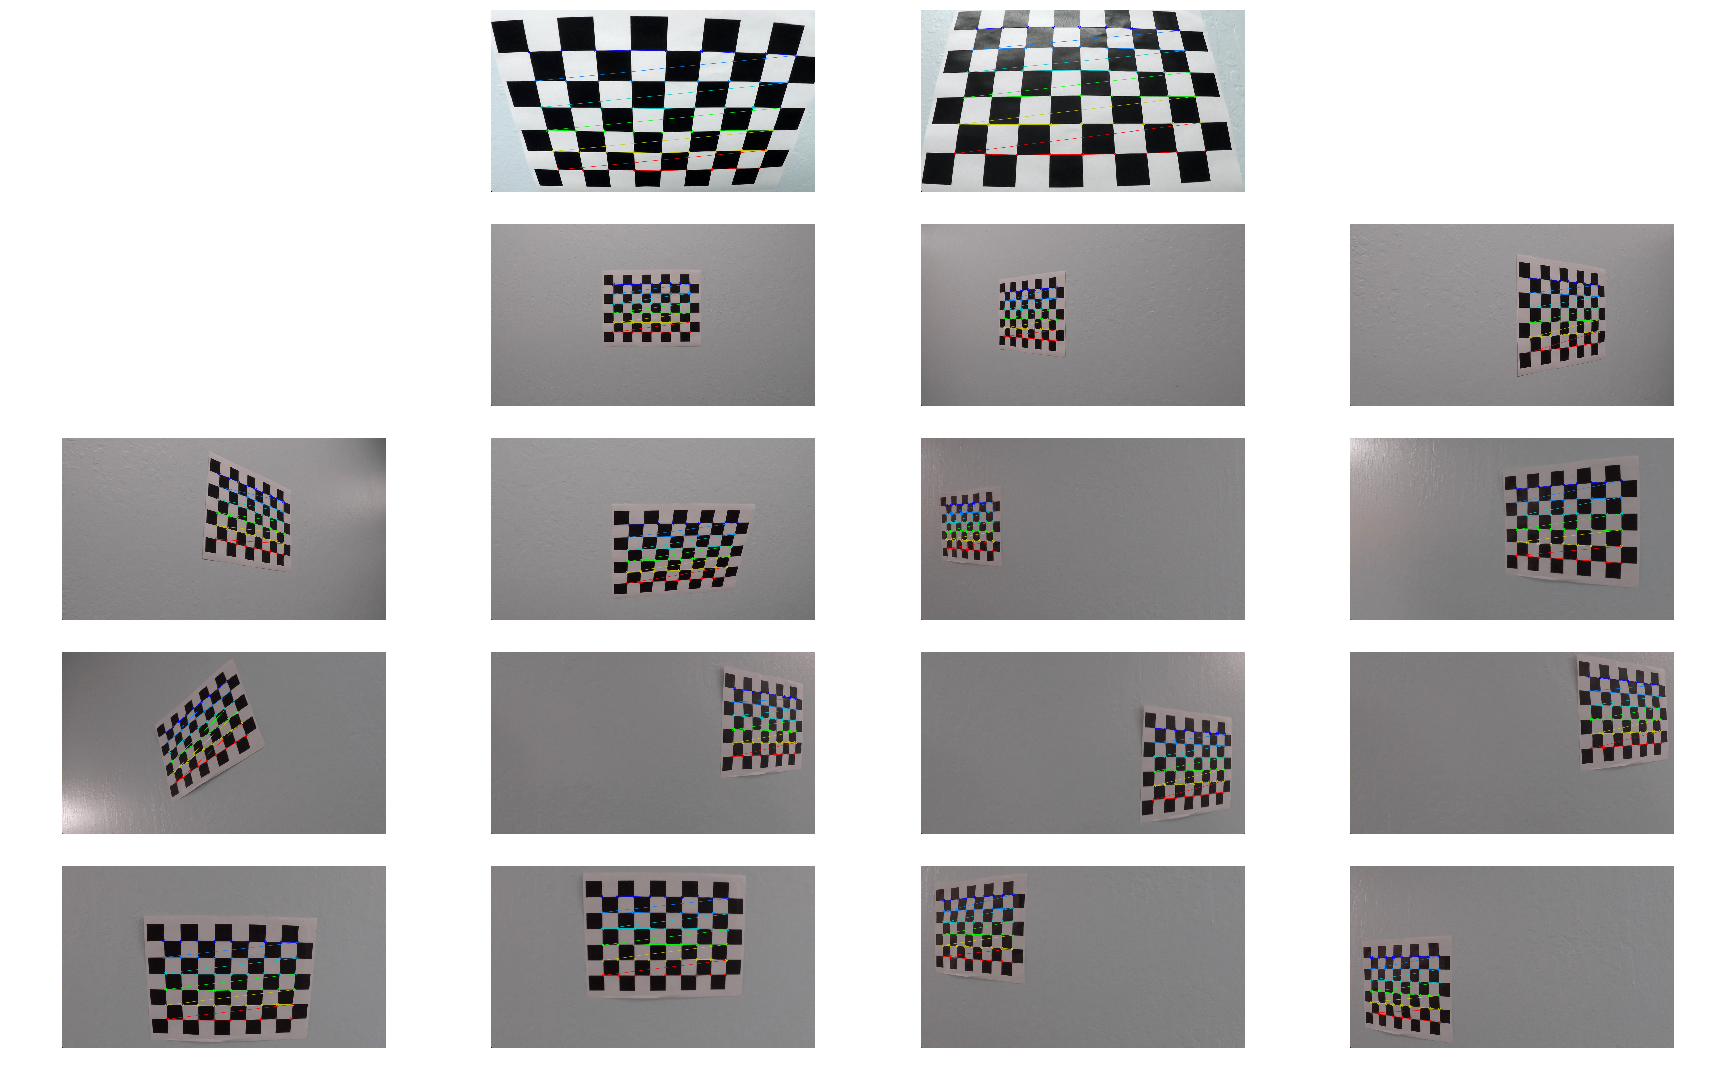

In [3]:
nx=9
ny=6
objp = np.zeros((ny*nx,3), dtype=np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = []   # 3d points in real world space
img_points = []   # 2d points in image plane.
corner_images = []  # images with found corners

# Make a list of calibration images
fig, axs = plt.subplots(5, 4, figsize=(24, 15))
fig.tight_layout()

img_shape = None
for i, ax in enumerate(axs.ravel()):
    ax.axis("off")
    img = cv2.imread(os.path.join(CALIBRATION_DIR, "calibration{}.jpg".format(i+1)))
    if img_shape == None:
        img_shape = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    if ret:
        obj_points.append(objp)
        img_points.append(corners)
        corner_images.append(img)
        ax.imshow(img)

In [4]:
ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_shape[::-1], None, None)
with open(os.path.join(CALIBRATION_DIR, CALIBRATION_FILE), "wb") as handle:
    np.save(handle, [camera_matrix, distortion_coeffs])

print("Camera matrix")
print(camera_matrix)
print("\nDistortion coefficients")
print(distortion_coeffs)

Camera matrix
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients
[[ -2.41017956e-01  -5.30721170e-02  -1.15810353e-03  -1.28318860e-04
    2.67125310e-02]]


### Undistortion and Perspective Transform

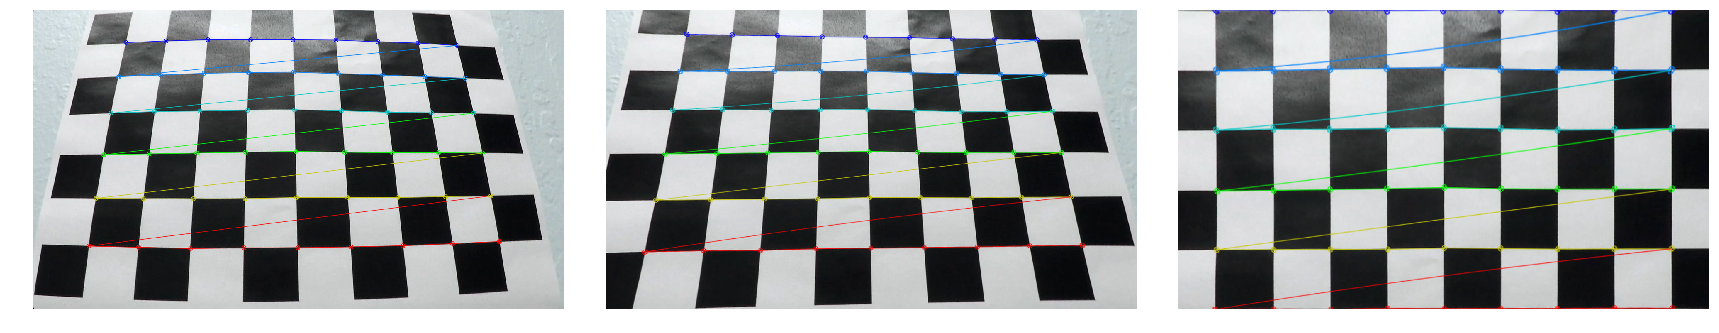

In [5]:
# Sanity check: Undistortion & Perspective Transform
fig, axs = plt.subplots(1, 3, figsize=(24, 10))
fig.tight_layout()

# undistort an image, and perspective warp first image for which perspective corners are found
for i, original_img in enumerate(corner_images):
    undistorted_img = cv2.undistort(original_img, camera_matrix, distortion_coeffs)
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)
    ret, undistorted_corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret:
        # get 4 corners for src polygon
        p0 = undistorted_corners[0]    # top left
        p1 = undistorted_corners[nx-1] # top right
        p2 = undistorted_corners[-1]   # bottom right
        p3 = undistorted_corners[-nx]  # bottom left
        src = np.concatenate((p0, p1, p2, p3))

        # define 4 destination points for perspective transform
        offset = 90
        rows, cols = img_shape
        dst = np.float32([[offset     , 0   ],
                          [cols-offset, 0   ],
                          [cols-offset, rows],
                          [offset     , rows]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undistorted_img, M, (cols,rows), flags=cv2.INTER_LINEAR)

        ax1, ax2, ax3 = axs
        ax1.imshow(original_img)
        ax1.axis("off")
        ax2.imshow(undistorted_img)
        ax2.axis("off")
        ax3.imshow(warped)
        ax3.axis("off")
        break

## Helper Functions

In [6]:
def undistort_image(img):
    """
    Remove camera distortion from image
    """
    return cv2.undistort(img, camera_matrix, distortion_coeffs)

def warp_image(img, src, dst, img_size):
    """
    Compute the perspective transformation from a source quadrangle to
    a destination and return the image with the perspective warp applied
    """
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def equalize_hist_hsv(img):
    """
    Convert image to HSV color space and perform Contrast Limited Adaptive
    Histogram Equalization on the V channel to help improve lane detection in shadows
    """
    h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return cv2.merge([h,s,clahe.apply(v)])

def filter_hsv_image(hsv_img,
                     yellow_dark=(15, 127, 127),
                     yellow_light=(25, 255, 255),
                     white_dark=(0, 0, 200),
                     white_light=(255, 30, 255)):
    """
    Convert image to HSV color space and suppress any colors
    outside of the defined color ranges. Convert to binary img.
    """
    yellow_dark = np.array(yellow_dark, dtype=np.uint8)
    yellow_light = np.array(yellow_light, dtype=np.uint8)
    yellow_range = cv2.inRange(hsv_img, yellow_dark, yellow_light)

    white_dark = np.array(white_dark, dtype=np.uint8)
    white_light = np.array(white_light, dtype=np.uint8)
    white_range = cv2.inRange(hsv_img, white_dark, white_light)

    filtered = cv2.bitwise_and(hsv_img, hsv_img, mask=(yellow_range | white_range))
    return filtered[:,:,2] # only keep the "value" channel of the image

def filter_sobel(img, orient="x", ksize=3, thresh=(0, 255)):
    """
    Calculate directional gradient
    """
    if orient == "x":
        out = np.abs(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize))
    else:
        out = np.abs(cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize))
    return np.uint8(255*out/np.max(out))

def binary_image(img, thresh=(0, 255)):
    """
    Set pixel values between threshold values to 1 and all others to 0
    """
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def get_base_x_vals(img):
    """
    Sum the columns and find the peak of the left and right halves of the histogram
    These will be the starting point for the left and right lines
    """
    mid_y = int(img.shape[0]/2)
    mid_x = int(img.shape[1]/2)
    histogram = np.sum(img[mid_y:,:], axis=0)
    left_x = np.argmax(histogram[:mid_x])
    right_x = np.argmax(histogram[mid_x:]) + mid_x
    return left_x, right_x

def solve_for_x(curve_coeffs, y_vals):
    """
    Given a set of y-values, return the corresponding x-values,
    based on the polynomial coefficients contained in `curve_coeffs`
    """
    x_vals = np.array([])
    fn = np.poly1d(curve_coeffs)
    return fn(y_vals)

def merge_x_and_y(x, y, invert=False):
    """
    Re-combine the x and y values of points
    """
    merged = np.vstack([x, y]).T
    return np.flipud(merged) if invert else merged

def get_curve_radius(points, y_val=360):
    """
    Rescale polynomial values to meters in x,y.
    Compute curve radius in meters.
    """
    y_val *= METERS_PER_PX_Y
    A, B, C = np.polyfit(points[:,1]*METERS_PER_PX_Y, points[:,0]*METERS_PER_PX_X, 2)

    # Calculate the radius of curvature at the given y value
    return (1 + (2*A*y_val + B)**2)**1.5 / np.abs(2*A)

def get_lane_widths(x_left, x_right):
    """
    Measure the distance in meters between the
    top and bottom values of the lane lines.
    """
    if len(x_left) == 0 or len(x_right) == 0:
        return 0., 0.
    top_width = (x_right[0] - x_left[0]) * METERS_PER_PX_X
    bottom_width = (x_right[-1] - x_left[-1]) * METERS_PER_PX_X
    return top_width, bottom_width

def get_lane_deviation(lane_center, img_width):
    """
    Measure the amount (in centimeters) the center
    of the vehicle varies from the center of the lane
    """
    img_center = img_width / 2
    lane_deviation = lane_center - img_center
    return lane_deviation * METERS_PER_PX_X * 100 

def get_curve_error(x_left, x_right):
    """
    Measure the difference between the 2 curves
    """
    if len(x_left) == 0 or len(x_right) == 0:
        return float('inf')

    # Compute the difference between the last x values of the left and right lanes
    x_diff = x_right[-1] - x_left[-1]

    # Translate the right lane so that the left and right lanes both have the same base x value
    x_right_prime = x_right - x_diff

    # Return sum of squared error to quantify the difference in the curves
    return np.sqrt(np.sum((x_left-x_right_prime)**2))

## Main Lane Detector Class
This class defines the main pipeline for processing an image from start to finish. The class can be initialized with a number of parameters, such as the number of frames to keep in a smoothing buffer, various error thresholds used for keeping or discarding lane detection frames, the size of the perspective quadrangles, etc.

In [14]:
class LaneDetector():
    def __init__(self,
                 show_diagnostics=False,
                 print_info_to_frame=False,
                 buffer_size=5,
                 num_search_windows=12,
                 search_window_margin=50,
                 minimum_search_pixels=50,
                 minimum_curve_pixels=50,
                 curve_line_width=25,
                 curve_error_thresh=1000.,
                 lane_width_error_thresh=1.,
                 lane_width_min=2.5,
                 lane_width_max=4.5,
                 quad_top=.651,
                 quad_lower=0.154,
                 quad_upper=0.444,
                 quad_projection_offset=.28,
                 yellow_dark=(15, 60, 60),
                 yellow_light=(37, 255, 255),
                 white_dark=(0, 0, 200),
                 white_light=(255, 50, 255)):
        self.diagnostic_image = None
        self.show_diagnostics = show_diagnostics
        self.print_info_to_frame = print_info_to_frame
        self.buffer_size = buffer_size
        self.left_lane_buffer = []
        self.right_lane_buffer = []
        self.left_curve_rad = 0.
        self.right_curve_rad = 0.
        self.curve_error = 0.
        self.curve_error_thresh = curve_error_thresh
        self.lane_width_top = 0.
        self.lane_width_bottom = 0.
        self.lane_width_error = 0.
        self.lane_deviation = 0.
        self.lane_width_error_thresh = lane_width_error_thresh
        self.lane_width_min = lane_width_min 
        self.lane_width_max = lane_width_max
        self.search_window_margin = search_window_margin
        self.num_search_windows = num_search_windows
        self.minimum_search_pixels = minimum_search_pixels
        self.minimum_curve_pixels = minimum_curve_pixels
        self.curve_line_width = curve_line_width
        self.quad_top = quad_top
        self.quad_lower = quad_lower
        self.quad_upper = quad_upper
        self.quad_projection_offset = quad_projection_offset
        self.yellow_dark = yellow_dark
        self.yellow_light = yellow_light
        self.white_dark = white_dark
        self.white_light = white_light

    def get_quadrangles(self, rows, cols):
        """
        Define 2 quadrangles for perspective transformation
        """
        # define pseudo tilted plane
        top = rows * self.quad_top
        left_lower  = cols * self.quad_lower
        left_upper  = cols * self.quad_upper
        right_lower = cols * (1.-self.quad_lower)
        right_upper = cols * (1.-self.quad_upper)
        src = np.float32([[left_lower , rows],
                          [right_lower, rows],
                          [right_upper,  top],
                          [left_upper ,  top]])

        # define projected destination plane equivalent to bird's eye view of tilted plane
        top = 0.
        left_side  = cols * self.quad_projection_offset
        right_side = cols * (1.-self.quad_projection_offset)
        dst = np.float32([[left_side , rows],
                          [right_side, rows],
                          [right_side,  top],
                          [left_side ,  top]])

        return src, dst
    
    def add_line_to_buffer(self, line, buffer):
        """
        Push the current line onto this buffer and drop the oldest line
        if there are more lines than the specified buffer size
        """
        buffer.append(line)
        return buffer[-self.buffer_size:]
    
    def sanity_check(self, x_left, x_right):
        """
        Only keep those lanes that meet the following criteria.
        """
        all_checks_pass = True
        
        if len(x_left) < self.minimum_curve_pixels or len(x_right) < self.minimum_curve_pixels:
            all_checks_pass = False

        # Check that lanes have similar curvature
        self.curve_error = get_curve_error(x_left, x_right)
        if self.curve_error > self.curve_error_thresh:
            all_checks_pass = False

        # Check that lanes are roughly parallel
        self.lane_width_top, self.lane_width_bottom = get_lane_widths(x_left, x_right)
        self.lane_width_error = abs(self.lane_width_top - self.lane_width_bottom)
        if self.lane_width_error > self.lane_width_error_thresh:
            all_checks_pass = False

        # Checking that they are separated by approximately the right distance horizontally
        if ((self.lane_width_top < self.lane_width_min) or
            (self.lane_width_top > self.lane_width_max) or
            (self.lane_width_bottom < self.lane_width_min) or
            (self.lane_width_bottom > self.lane_width_max)):
            all_checks_pass = False
        
        # All checks pass
        return all_checks_pass

    def lookahead_search(self, img, curve_coeffs, x_vals, hide_visualization=False):
        """
        Search for points within a margin to the left and right of the given curve
        """
        y_vals = np.linspace(0, img.shape[0]-1, x_vals.shape[0])
        x_curve = solve_for_x(curve_coeffs, y_vals)
        
        if self.show_diagnostics and not hide_visualization:
            line_img = np.zeros_like(self.diagnostic_image)
            line = merge_x_and_y(x_curve, y_vals)
            cv2.polylines(line_img, [line.astype(int)], False, (0,255,255), self.search_window_margin*2)
            cv2.addWeighted(self.diagnostic_image, 1, line_img, 0.5, 0, self.diagnostic_image)

        return ((x_vals >= (x_curve-self.search_window_margin)) &
                (x_vals < (x_curve+self.search_window_margin)))

    def sliding_window_search(self, img, initial_x, y_vals, x_vals, hide_visualization):
        rows, cols = img.shape
        
        # height of sliding windows
        win_height = int(rows/self.num_search_windows)

        # store lane pixel indices
        indices = []

        # set the first x position to the initial x
        current_x = initial_x
        for y in reversed(range(0, rows, win_height)):
            # window boundaries
            y_lower = y
            y_upper = y + win_height
            x_left = current_x - self.search_window_margin
            x_right = current_x + self.search_window_margin

            # Draw the windows on the diagnostic image
            if self.show_diagnostics and not hide_visualization:
                cv2.rectangle(self.diagnostic_image, (x_left,y_lower), (x_right,y_upper), (0,200,200), 2)

            # Identify the nonzero pixels in x and y within the window
            found_indices = ((y_vals >= y_lower) & (y_vals < y_upper) &
                             (x_vals >= x_left) & (x_vals < x_right)).nonzero()[0]

            # Append these indices to the lists
            indices.append(found_indices)

            # if found > self.minimum_search_pixels, recenter next window on their mean position
            if len(found_indices) >= self.minimum_search_pixels:
                current_x = int(np.mean(x_vals[found_indices]))

        # Concatenate and return the found indices
        return np.concatenate(indices) 

    def get_lane_points(self, img, initial_x_val, y_vals, x_vals, lane_buffer, hide_visualization=False):
        """
        Find the points that are most likely to belong to the lane line.
        If lane buffer is empty, use sliding window search, otherwise, search
        for points within a margin to the left and right of the most recently buffered curve
        """
        if len(lane_buffer) > 1:
            curve_coeffs = lane_buffer[0]
            indices = self.lookahead_search(img, curve_coeffs, x_vals, hide_visualization)
        else:
            indices = self.sliding_window_search(img, initial_x_val, y_vals, x_vals, hide_visualization)

        # Extract x and y pixel coordinates
        points = {"X": x_vals[indices], "Y": y_vals[indices]}
        
        # highlight the identified pixels
        if self.show_diagnostics:
            self.diagnostic_image[points["Y"], points["X"], :] = (0,190,0)
        
        return points

    def get_curves(self, img, hide_visualization=False):
        """
        Extract curves from the current frame, sanity check the values and
        either add the curve coefficients to the lane buffer or else discard
        the curve values and fall back to the buffered (previously approved) lanes
        """
        # find the initial x values from which to start searching for curves
        base_x_left, base_x_right = get_base_x_vals(img)
        
        # get all the nonzero points in the image and find those
        # we think best represent the left and right lane lines
        nonzero_y, nonzero_x = img.nonzero()
        points_left = self.get_lane_points(img, base_x_left, nonzero_y, nonzero_x, self.left_lane_buffer[1:],
                                          hide_visualization=hide_visualization)
        points_right = self.get_lane_points(img, base_x_right, nonzero_y, nonzero_x, self.right_lane_buffer[1:],
                                           hide_visualization=hide_visualization)

        # y values for drawing the curves
        rows, cols = img.shape[:2]
        y_vals = np.linspace(0, rows-1, rows)
        
        # fit an initial set of curve coefficients to the left and right sets of points
        x_left = np.array([])
        x_right = np.array([])
        if len(points_left["X"]) > 1 and len(points_left["Y"]) > 1:
            curve_coeffs_left = np.polyfit(points_left["Y"], points_left["X"], 2)
            x_left = solve_for_x(curve_coeffs_left, y_vals)
            
        if len(points_right["X"]) > 1 and len(points_right["Y"]) > 1:
            curve_coeffs_right = np.polyfit(points_right["Y"], points_right["X"], 2)
            x_right = solve_for_x(curve_coeffs_right, y_vals)    
        
        # if current x_coords pass sanity check, store curve coefficients in lane buffers
        if self.sanity_check(x_left, x_right):
            self.left_lane_buffer = self.add_line_to_buffer(curve_coeffs_left, self.left_lane_buffer)
            self.right_lane_buffer = self.add_line_to_buffer(curve_coeffs_right, self.right_lane_buffer)
        
        # Recompute the curve coefficients using the mean values
        # from the lane buffers to draw the final curve
        mean_curve_coeffs_left = np.mean(self.left_lane_buffer, axis=0)
        mean_curve_coeffs_right = np.mean(self.right_lane_buffer, axis=0)

        # solve for x for left and right lanes
        x_left = solve_for_x(mean_curve_coeffs_left, y_vals)
        x_right = solve_for_x(mean_curve_coeffs_right, y_vals)
        
        # get the mean of the two curves in order to compute the lane deviation
        x_mid = np.mean((x_left, x_right), axis=0)

        # merge x and y coords for final left and right curves
        curve_left = merge_x_and_y(x_left, y_vals)
        curve_right = merge_x_and_y(x_right, y_vals, invert=True)

        # get the curve midway between the lane lines
        curve_mid = merge_x_and_y(x_mid, y_vals)
        
        # save curve radii and lane deviation
        self.left_curve_rad = get_curve_radius(curve_left)
        self.right_curve_rad = get_curve_radius(curve_right)
        self.lane_deviation = get_lane_deviation(x_mid[-1], cols)

        if self.show_diagnostics and not hide_visualization:
            cv2.polylines(self.diagnostic_image, [curve_left.astype(int)], False, (255,0,0), 5)
            cv2.polylines(self.diagnostic_image, [curve_right.astype(int)], False, (255,0,0), 5)
            cv2.polylines(self.diagnostic_image, [curve_mid.astype(int)], False, (0,190,190), 5)
            
            # vehicle center marker
            mid = int(cols / 2)
            marker = np.array(((mid-30, rows   ),
                                 (mid+30, rows   ),
                                 (   mid, rows-30),
                                 (mid-30, rows   )), dtype=int)
            marker_color = (190,0,0) if abs(self.lane_deviation) > 30 else (0,100,0)
            cv2.fillPoly(self.diagnostic_image, [marker], marker_color)

        return curve_left, curve_right
    
    def draw_curves(self, img):
        """
        Generate curve image to be overlayed atop the original image
        """
        curve_image = np.zeros(img.shape + (3,), dtype=np.uint8)

        curve_left, curve_right = self.get_curves(img)
        curve_poly = np.vstack((curve_left, curve_right))

        cv2.fillPoly(curve_image, [curve_poly.astype(int)], (0,255,255))
        cv2.polylines(curve_image, [curve_left.astype(int)], False, (255,255,0), self.curve_line_width)
        cv2.polylines(curve_image, [curve_right.astype(int)], False, (255,255,0), self.curve_line_width)
        return curve_image
    
    def print_info(self, img=np.array([]), pass_color=(0,100,0), fail_color=(190,0,0)):
        """
        Utility function to print relevant information on the output image
        """
        text_color = lambda n, thresh: fail_color if n > thresh else pass_color

        info = [("Left  Rad: {:.1f} m".format(self.left_curve_rad), (0,0,0)),
                ("Right Rad: {:.1f} m".format(self.right_curve_rad), (0,0,0)),
                ("Top Width: {0:.3f} m".format(self.lane_width_top), (0,0,0)),
                ("Bot Width: {0:.3f} m".format(self.lane_width_bottom), (0,0,0)),
                ("Lane Center Deviation: {0:.2f} cm".format(self.lane_deviation), (0,0,0)),
                ("Lane Width Error: {:.3f}".format(self.lane_width_error), text_color(self.lane_width_error,
                                                                                      self.lane_width_error_thresh)),
                ("Curve Match Error: {0:.2f}".format(self.curve_error), text_color(self.curve_error,
                                                                                   self.curve_error_thresh)),]

        y0, dy = 35, 40
        for i, line in enumerate(info):
            text, color = line
            if len(img) > 0:
                cv2.putText(img, text, (15, y0 + i*dy), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            else:
                print(text)
    
    def assemble_diagnostic_screen(self, img, warped, curves):
        """
        stack a few views of the current frame together for diagnostic purposes
        """
        right = np.vstack((warped, self.diagnostic_image))
        right = cv2.resize(right, (640,720), interpolation=cv2.INTER_AREA)
        return np.hstack((img, right))
    
    def process_frame(self, img):
        """
        The main pipeline of the image processing algorithm
        """
        rows, cols = img.shape[:2]
        
        # get the quadrangles to use for the perspective transform
        src_quad, dst_quad = self.get_quadrangles(rows, cols)
        
        # correct for camera lens distortion
        undistorted = undistort_image(img)
        
        # transform perspective to bird's eye view
        warped = warp_image(undistorted, src_quad, dst_quad, (cols,rows))
        
        # filter image to exclude all values not in yellow and white ranges
        hsv = equalize_hist_hsv(warped)
        filtered = filter_hsv_image(hsv,
                                    yellow_dark=self.yellow_dark,
                                    yellow_light=self.yellow_light,
                                    white_dark=self.white_dark,
                                    white_light=self.white_light)
        binary = binary_image(filtered)

        # create diagnostic image if show_diagnostics is set to True
        if self.show_diagnostics:
            self.diagnostic_image = np.dstack((binary,binary,binary)) * 127
        
        # get the rendered curve image to overlay
        curves = self.draw_curves(binary)
        
        # transform perspective of curve image to match original input image
        unwarped_curves = warp_image(curves, dst_quad, src_quad, (cols,rows))
        
        # overlay the curve image atop the original input image
        img = cv2.addWeighted(undistorted, 1, unwarped_curves, 0.5, 0)
        
        # if show_diagnostics is set to True, output a diagnostic image
        if self.show_diagnostics:
            img = self.assemble_diagnostic_screen(img, warped, curves)
        
        # print relevant data onto the image
        if self.print_info_to_frame:
            self.print_info(img)
        return img

### Tuning the quadrangle shapes for perspective transform

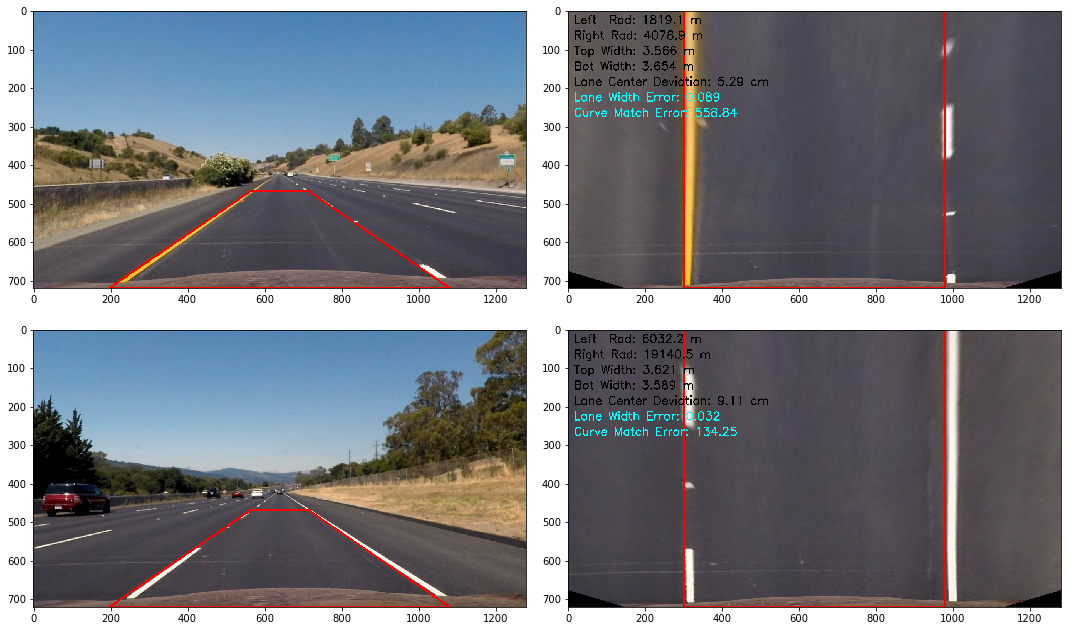

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.tight_layout()
for i, row in enumerate(axs):
    ld = LaneDetector(quad_top=.651,
                      quad_lower=0.154,
                      quad_upper=0.442,
                      quad_projection_offset=.235)
    ax1, ax2 = row
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "straight_lines{}.jpg".format(i+1)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = undistort_image(image)
    warped = warp_image(undistorted, src, dst, (cols,rows))
    
    # get the filtered, binary image for the purpose of calculating the curve values
    hsv = equalize_hist_hsv(warped)
    filtered = filter_hsv_image(hsv,
                                yellow_dark=ld.yellow_dark,
                                yellow_light=ld.yellow_light,
                                white_dark=ld.white_dark,
                                white_light=ld.white_light)
    ld.get_curves(binary_image(filtered))

    # draw the source and destination quadrangles
    cv2.polylines(undistorted, [src.astype(int)], True, (255,), 4)
    cv2.polylines(warped, [dst.astype(int)], True, (255,), 4)

    ld.print_info(warped, pass_color=(0,255,255))
    ax1.imshow(undistorted)
    ax2.imshow(warped)

### Transformed input frames

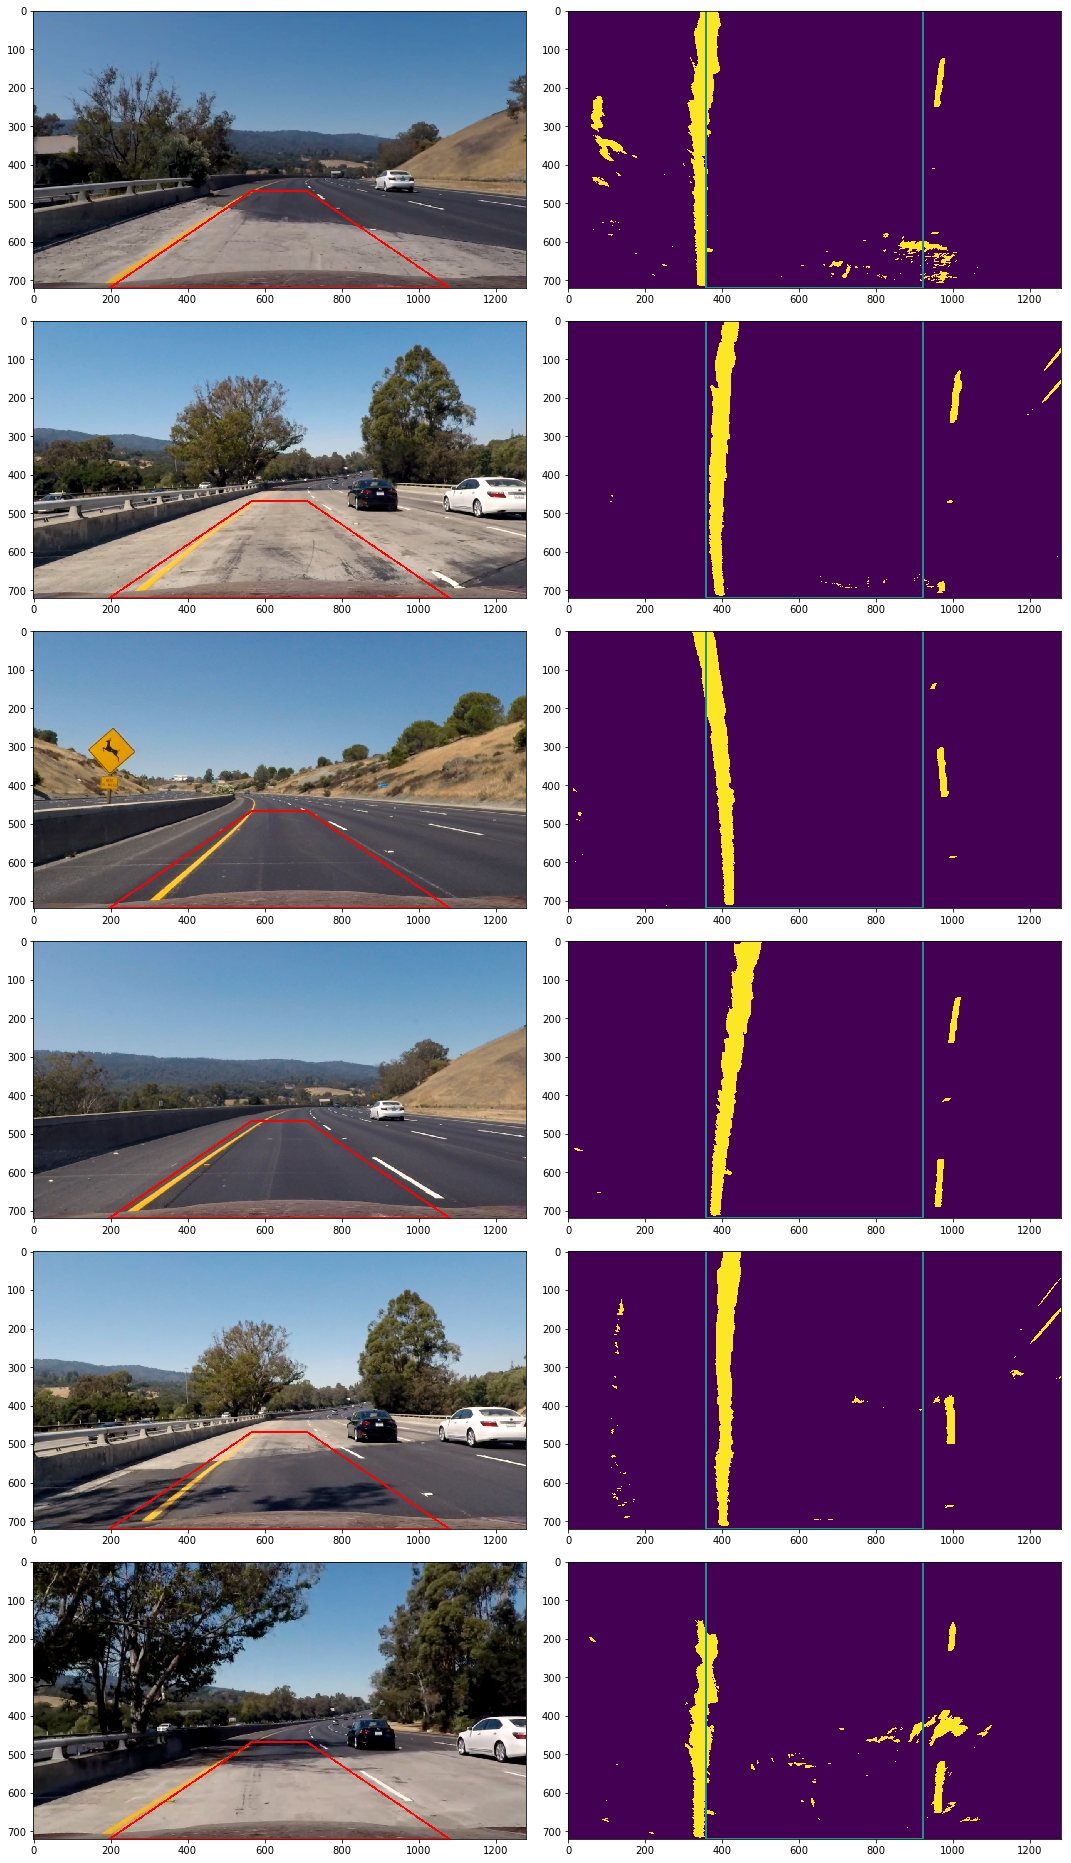

In [9]:
fig, axs = plt.subplots(6, 2, figsize=(15, 26))
fig.tight_layout()
for i, row in enumerate(axs):
    ld = LaneDetector(yellow_dark=(15, 70, 80),
                      yellow_light=(40, 255, 255),
                      white_dark=(0, 0, 200),
                      white_light=(255, 30, 255))
    ax1, ax2 = row
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = undistort_image(image)
    warped = warp_image(undistorted, src, dst, (cols,rows))
    hsv = equalize_hist_hsv(warped)
    filtered = filter_hsv_image(hsv,
                                yellow_dark=ld.yellow_dark,
                                yellow_light=ld.yellow_light,
                                white_dark=ld.white_dark,
                                white_light=ld.white_light)
    binary = binary_image(filtered) * 2
    
    cv2.polylines(undistorted, [src.astype(int)], True, (255,), 4)
    cv2.polylines(binary, [dst.astype(int)], True, (1,), 4)
    ax1.imshow(undistorted)
    ax2.imshow(binary)

### Finding the Initial X Values

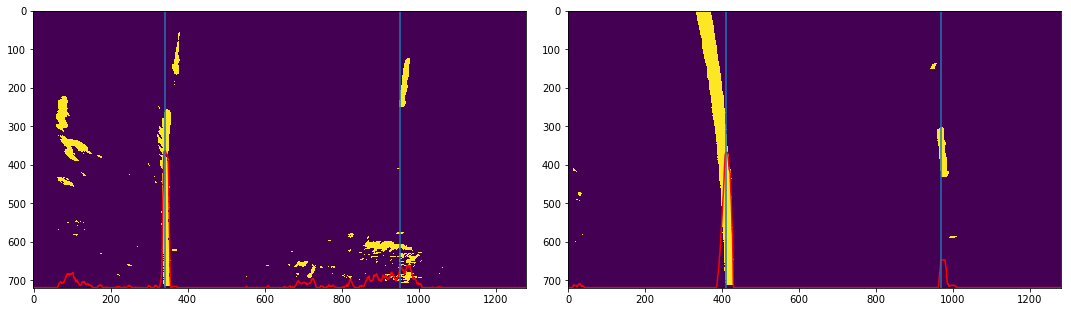

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector()
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i * 2)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = undistort_image(image)
    warped = warp_image(undistorted, src, dst, (cols,rows))

    hsv = equalize_hist_hsv(warped)
    binary = binary_image(filter_hsv_image(hsv))

    mid_y = int(img.shape[0]/2)
    mid_x = int(img.shape[1]/2)
    histogram = np.sum(binary[mid_y:,:], axis=0)
    initial_x_left = np.argmax(histogram[:mid_x])
    initial_x_right = np.argmax(histogram[mid_x:]) + mid_x

    x_vals = np.linspace(0, img.shape[1]-1, img.shape[1])
    y_vals = img.shape[0] - 1 - histogram
    
    ax.imshow(binary)
    ax.plot(x_vals, y_vals, color='r')
    ax.axvline(x=initial_x_left)
    ax.axvline(x=initial_x_right)

### Visualizing the Sliding Window Search

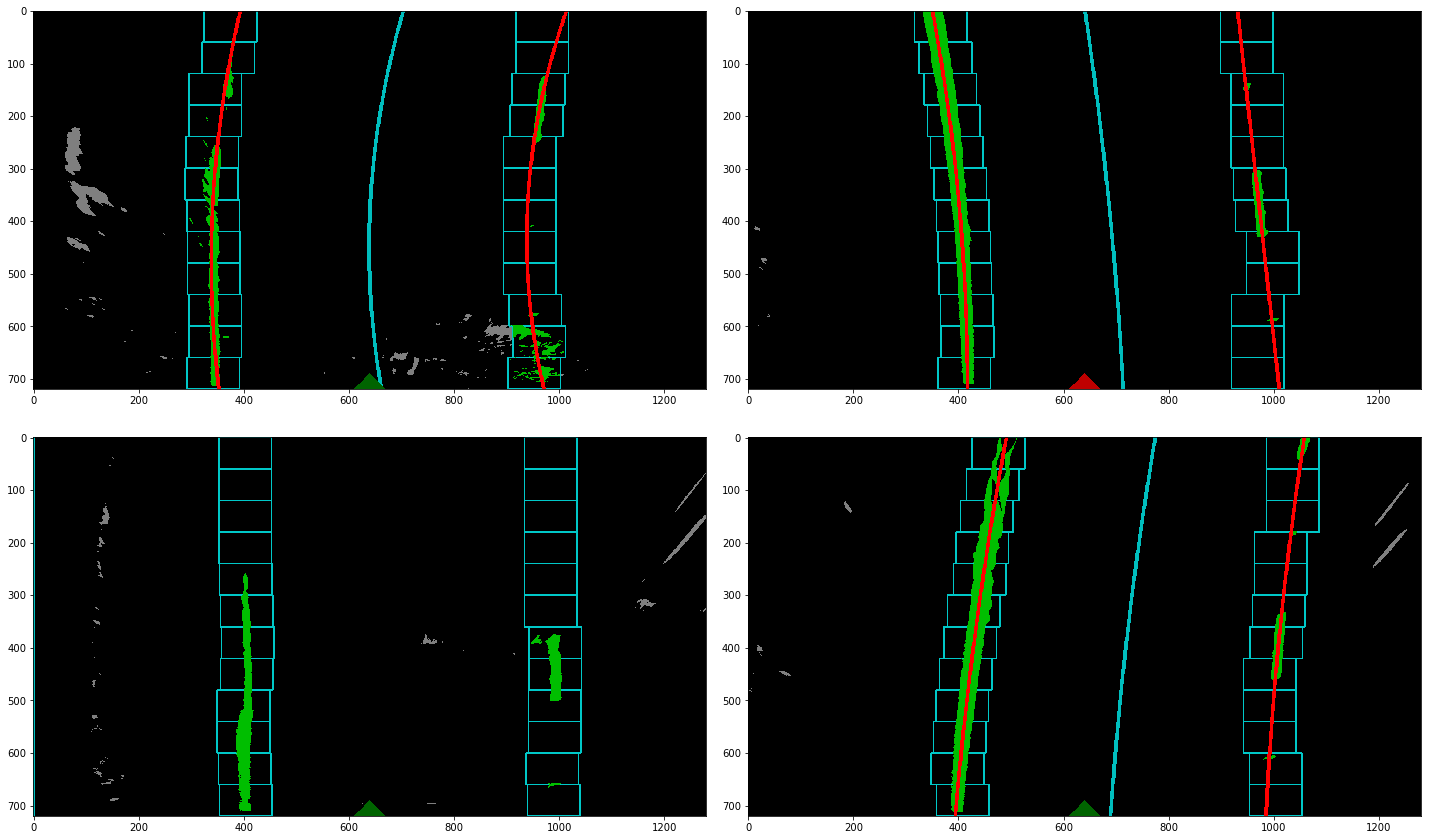

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector(show_diagnostics=True,
                      yellow_dark=(15, 90, 80),
                      yellow_light=(37, 255, 255),
                      white_dark=(0, 0, 200),
                      white_light=(255, 30, 255))
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i*2)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = undistort_image(image)
    warped = warp_image(undistorted, src, dst, (cols,rows))
    hsv = equalize_hist_hsv(warped)
    filtered = filter_hsv_image(hsv,
                            yellow_dark=ld.yellow_dark,
                            yellow_light=ld.yellow_light,
                            white_dark=ld.white_dark,
                            white_light=ld.white_light)
    binary = binary_image(filter_hsv_image(hsv))

    ld.diagnostic_image = np.dstack((binary,binary,binary)) * 127
    ld.get_curves(binary)
    ax.imshow(ld.diagnostic_image)

### Visualizing the Lookahead Search

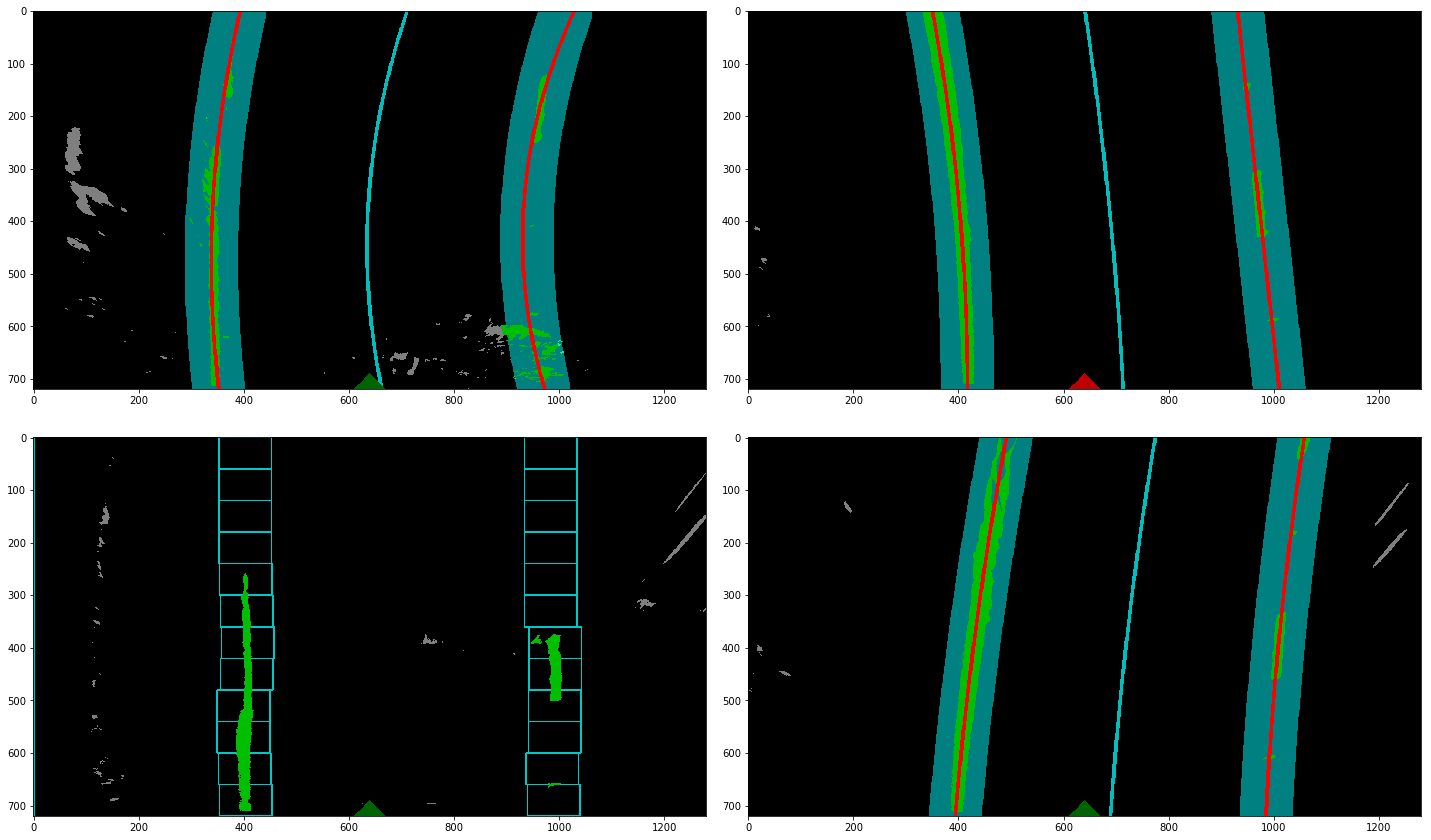

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector(show_diagnostics=True)
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i*2)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = undistort_image(image)
    warped = warp_image(undistorted, src, dst, (cols,rows))
    hsv = equalize_hist_hsv(warped)
    binary = binary_image(filter_hsv_image(hsv))

    ld.diagnostic_image = np.dstack((binary,binary,binary)) * 127
    # run get_curves twice to force fit values onto lookahead search for visualization purposes
    ld.get_curves(binary, hide_visualization=True)
    ld.get_curves(binary)
    ax.imshow(ld.diagnostic_image)

### Example Diagnostic Screen

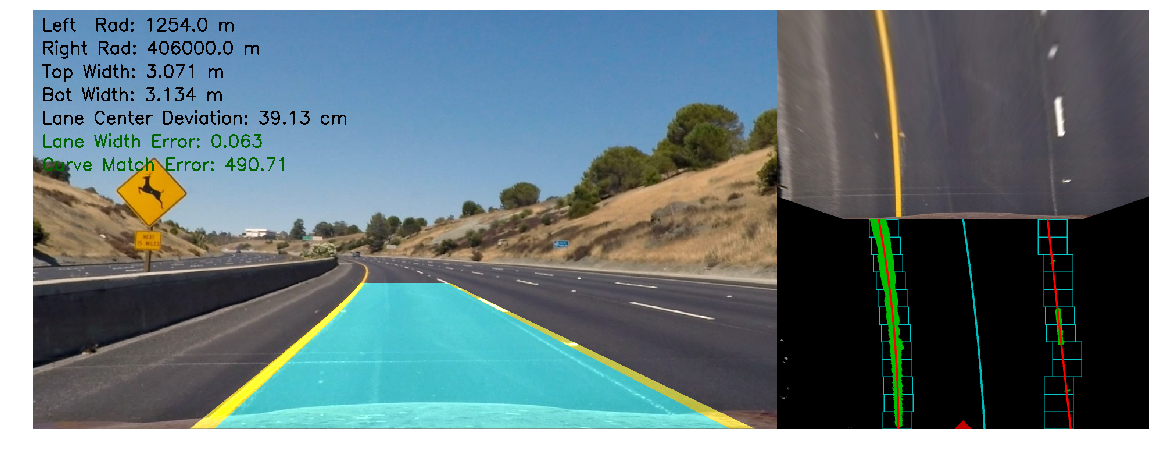

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(2)))
ld = LaneDetector(show_diagnostics=True, print_info_to_frame=True)
ax.axis("off")
ax.imshow(ld.process_frame(im))

## Processing the Video

In [16]:
ld = LaneDetector(show_diagnostics=False, print_info_to_frame=True, buffer_size=3)

input1 = os.path.join(INPUT_VIDEOS_DIR, "project_video.mp4")
output1 = os.path.join(OUTPUT_VIDEOS_DIR, "project_video_process.mp4")
clip1 = VideoFileClip(input1)
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_process.mp4
[MoviePy] Writing video output_videos/project_video_process.mp4


100%|█████████▉| 1260/1261 [01:55<00:00, 11.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_process.mp4 

CPU times: user 3min 11s, sys: 21.4 s, total: 3min 32s
Wall time: 1min 55s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

## Diagnostic Video

In [20]:
ld = LaneDetector(show_diagnostics=True, print_info_to_frame=True,)

input2 = os.path.join(INPUT_VIDEOS_DIR, "project_video.mp4")
output2 = os.path.join(OUTPUT_VIDEOS_DIR, "project_video_diagnostic.mp4")
clip2 = VideoFileClip(input2)
project_clip = clip2.fl_image(ld.process_frame)
%time project_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_diagnostic.mp4
[MoviePy] Writing video output_videos/project_video_diagnostic.mp4


100%|█████████▉| 1260/1261 [38:45<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_diagnostic.mp4 

CPU times: user 39min 19s, sys: 50.7 s, total: 40min 9s
Wall time: 38min 46s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

## Challenge Video

In [18]:
ld = LaneDetector(show_diagnostics=True,
                  print_info_to_frame=True,
                  curve_error_thresh=1500.,
                  lane_width_error_thresh=1.,
                  lane_width_min=2.5,
                  lane_width_max=4.5,
                  quad_top=.69,
                  quad_lower=0.154,
                  quad_upper=0.429,
                  quad_projection_offset=.213)

input3 = os.path.join(INPUT_VIDEOS_DIR, "challenge_video.mp4")
output3 = os.path.join(OUTPUT_VIDEOS_DIR, "challenge_video_process.mp4")
clip3 = VideoFileClip(input3)
project_clip = clip3.fl_image(ld.process_frame)
%time project_clip.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_process.mp4
[MoviePy] Writing video output_videos/challenge_video_process.mp4


100%|██████████| 485/485 [10:21<00:00,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_process.mp4 

CPU times: user 10min 39s, sys: 15.4 s, total: 10min 54s
Wall time: 10min 22s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))